In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the data
data = pd.read_csv('../../.dataset/BTC-USD-3.2018-3.2024.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
1,2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2,2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
3,2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
4,2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [3]:
# Set the date as the index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-01,10385.000000,11052.299805,10352.700195,10951.000000,10951.000000,7317279744
2018-03-02,10977.400391,11189.000000,10850.099609,11086.400391,11086.400391,7620590080
2018-03-03,11101.900391,11528.200195,11002.400391,11489.700195,11489.700195,6690570240
2018-03-04,11497.400391,11512.599609,11136.099609,11512.599609,11512.599609,6084149760
2018-03-05,11532.400391,11704.099609,11443.900391,11573.299805,11573.299805,6468539904


In [4]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    # df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean() 
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    # df['MA200_low'] = df['Low'].rolling(window=200).min()
    # df['MA14_low'] = df['Low'].rolling(window=14).min()
    # df['MA200_high'] = df['High'].rolling(window=200).max()
    # df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    # Shifts (one day before and two days before)
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']

    # Bollinger Bands
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)
    df['Bollinger_Middle'] = df['MA20'] 
    
    # Relative Strength Index (RSI)
    # df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    # Relative Strength Index (RSI) not using the K-ratio
    # df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Moving Average Convergence/Divergence (MACD)
    df['MACD'] = df['EMA12'] - df['EMA26']
    
    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    # 
    return df

                  Close       MACD  Bollinger_Upper  Bollinger_Lower         MA26        EMA20
Date                                                                                          
2018-10-02  6556.100098 -10.684094      6792.186134      6313.780956  6502.164645  6584.695354
2018-10-03  6502.589844 -16.371112      6792.002241      6312.492828  6503.530799  6576.875781
2018-10-04  6576.689941 -14.729068      6794.686803      6316.206264  6517.019644  6576.858082
2018-10-05  6622.479980  -9.621947      6800.417097      6318.403948  6529.389648  6581.203025
2018-10-06  6588.310059  -8.236796      6803.448380      6322.485653  6539.336182  6581.879885
                  Close       MACD  Bollinger_Upper  Bollinger_Lower         MA26        EMA20
Date                                                                                          
2018-10-02  6556.100098 -10.684094      6792.186134      6313.780956  6502.164645  6584.695354
2018-10-03  6502.589844 -16.371112      6792.00224

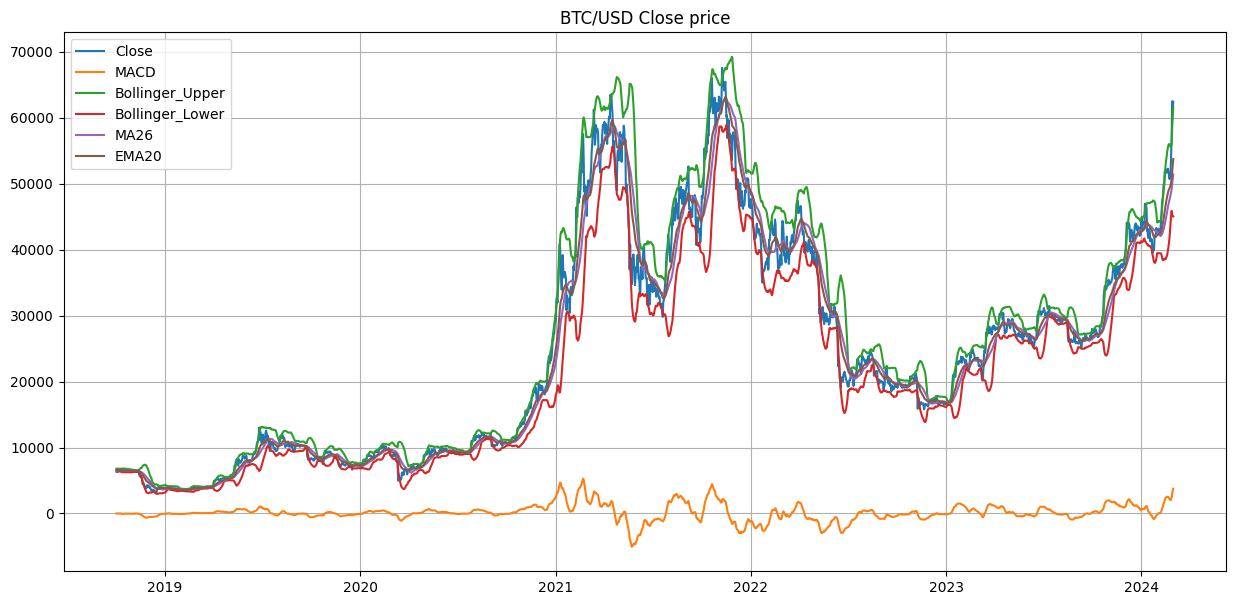

In [5]:
# List of considered Features
FEATURES = [
            # 'High',
            # 'Low',
            # 'Open',
            'Close',
            # 'Volume',
#             'Day',
#             'Month',
#             'Year',
            # 'Adj Close',
#              'close_shift-1',
#              'close_shift-2',
            'MACD',
            # 'RSI',
            # 'MA200',
#             'MA200_high',
#             'MA200_low',
            'Bollinger_Upper',
            'Bollinger_Lower',
            # 'MA100',            
#             'MA50',
            'MA26',
#             'MA14_low',
#             'MA14_high',
            # 'MA12',
            'EMA20',
            # 'EMA100',
#             'EMA200',
#               'DIFF-MA200-MA50',
#               'DIFF-MA200-MA100',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE',
            # 'MA20dSTD',
            # 'Close_Diff',
            # 'K-ratio'
           ]

# Create the dataset with features
df_features = createFeatures(data)

# Shift the timeframe by 10 month -> Start date is 2010-11-01
use_start_date = pd.to_datetime("2018-10-01")
df_features = df_features[df_features.index > use_start_date].copy()

# Filter the data to the list of FEATURES
df_filtered = df_features[FEATURES].copy()

# Filter the data to the list of FEATURES
print(df_filtered.head().to_string())  
    

# Filter the data to the list of FEATURES
df_filtered = df_filtered.dropna()
print(df_filtered.head().to_string())

# Create the lineplot
plt.figure(figsize=(15, 7))
plt.plot(df_filtered)
plt.title('BTC/USD Close price')
plt.grid()
plt.legend(df_filtered.columns)
plt.show()


In [6]:
# Scale the data
df = df_filtered.copy()

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data = scaler.fit_transform(df)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_close = pd.DataFrame(df['Close'])
np_close = scaler_pred.fit_transform(df_close)

In [7]:
print(df_filtered.shape)

(1978, 6)


In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Training, validation, test
train_size = int(len(np_data) * 0.70)
test_size = len(np_data) - train_size
train_data, test_data = np_data[0:train_size], np_data[train_size:len(np_data)]

In [9]:
print(train_data.shape, test_data.shape)

(1384, 6) (594, 6)


In [10]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(data, time_steps):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(data_len - time_steps):
        row = [r for r in data[i: i + time_steps]]
        x.append(row)
        label = data[i + time_steps][0]
        y.append(label)
    return np.array(x), np.array(y)
    

# Generate training data and test data
X_train, y_train = partition_dataset(train_data, sequence_length)
X_test, y_test = partition_dataset(test_data, sequence_length)

In [11]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1377, 7, 6) (1377,)
(587, 7, 6) (587,)


In [12]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
x_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(FEATURES))
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(FEATURES))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1377, 7, 6) (1377,)
(587, 7, 6) (587,)


timesteps: 7, features:6
Parameters: ['epochs 100', 'batch_size 64', 'optimizer adam with learn rate standard', 'loss mean_squared_error']
Epoch 1/100
22/22 [==============================] - 4s 19ms/step - loss: 0.0330 - val_loss: 0.0023
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 6.4370e-04
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 6.3296e-04
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 5.7876e-04
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 5.3693e-04
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 9.6758e-04 - val_loss: 5.3711e-04
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 9.1524e-04 - val_loss: 4.7268e-04
Epoch 8/100
22/22 [==============================] - 0s 6ms/step - loss: 8.6394e-04 - val_loss: 4.5934e-04
Epoch 9/100
22/22 [=========

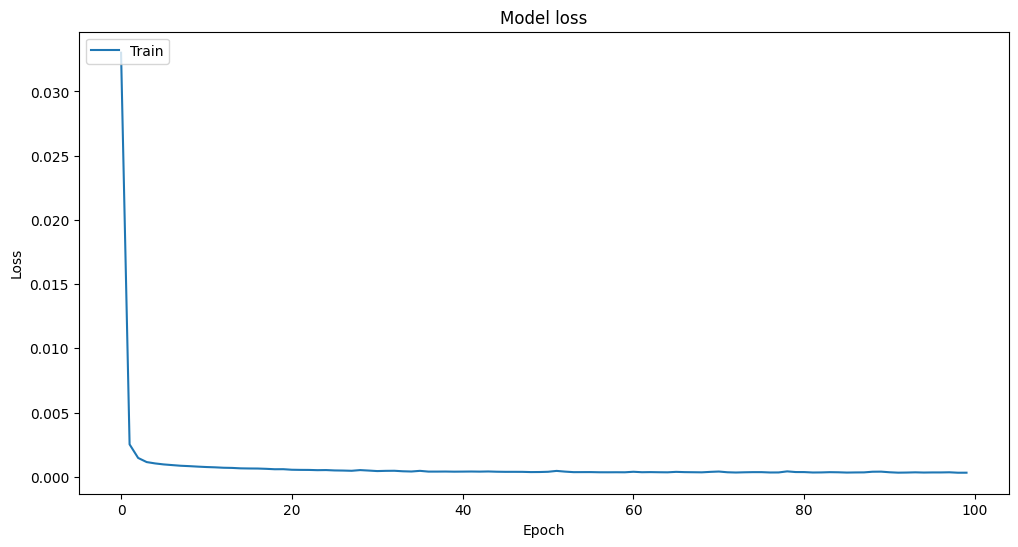

In [13]:
# Configure the neural network model
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = X_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(GRU(n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(1))


# Configure the Model   
optimizer='adam'; loss='mean_squared_error'; epochs = 100; batch_size = 64

# uncomment to customize the learning rate
learn_rate = "standard" # 0.05

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

(594, 7, 6)
19/19 [==============================] - 0s 2ms/step


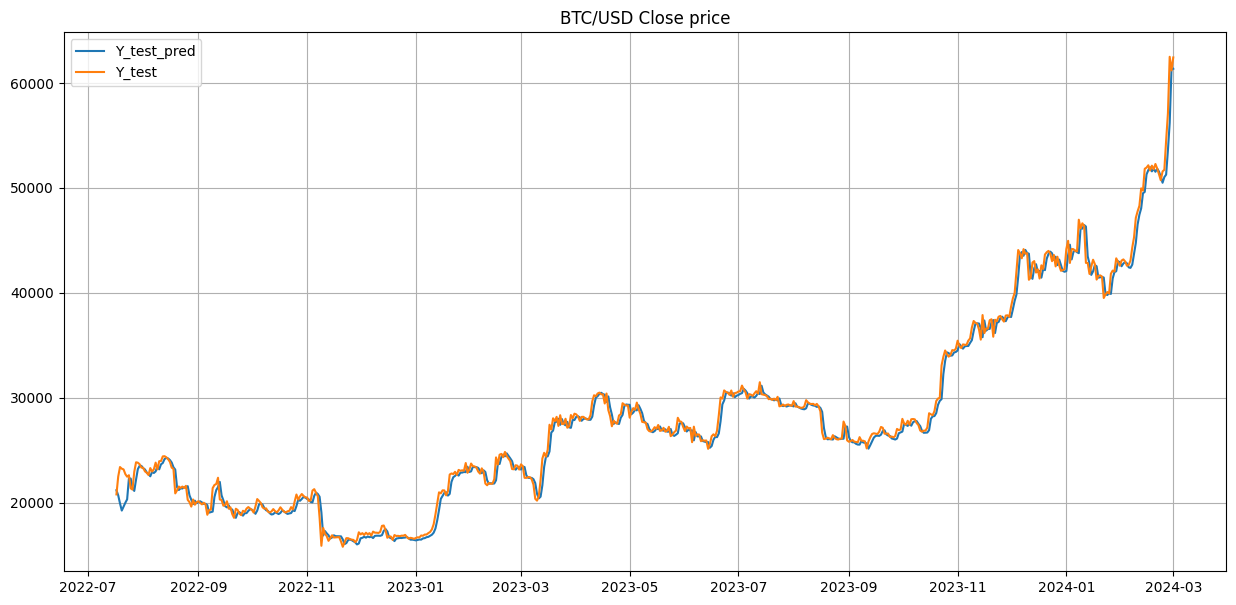

In [14]:
# Get x_val, x_test for the prediction from the last sequence_length days of the training set and the first sequence_length days of the validation set
x_test_pred = np.concatenate((x_train[-sequence_length:], x_test))
print(x_test_pred.shape)
# Predict the values
y_test_pred = model.predict(x_test_pred)

# Inverse the scaling of the predicted values
y_test_pred_unscaled = scaler_pred.inverse_transform(y_test_pred)


# Create a dataframe for the test set matching sliding window
day_test = pd.to_datetime(df_filtered.index[-len(y_test_pred):])
df_test = pd.DataFrame(day_test, columns=['Date'])
df_test['Y_test_pred'] = y_test_pred_unscaled
df_test['Y_test'] = df_filtered['Close'][-len(y_test_pred):].values
df_test.set_index('Date', inplace=True)


# # Plot df_val and df_test
plt.figure(figsize=(15, 7))
plt.plot(df_test['Y_test_pred'], label='Y_test_pred')
plt.plot(df_test['Y_test'], label='Y_test')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


In [15]:
df_temp = pd.DataFrame(np_data, columns=FEATURES)
# Loop to predict the next day
i = 1
num_days = 90
while i <= num_days:
    # Get the last sequence_length days
    x_pred = df_temp[-sequence_length:]
    x_pred_input = x_pred.values
    x_pred_input = x_pred_input.reshape(1, sequence_length, len(FEATURES))
    print("x_pred_input of day " + str(i) + ": \n" + str(x_pred_input))
    # Predict the value
    y_pred = model.predict(x_pred_input)
    y_pred_unscaled = scaler_pred.inverse_transform(y_pred)
    print("y_pred of day " + str(i) + ": " + str(y_pred_unscaled))
    # unscaling the data df_temp
    df_temp = pd.DataFrame(scaler.inverse_transform(df_temp), columns=FEATURES)
    # Add the predicted value to the df_temp dataframe
    df_temp = pd.concat([df_temp, pd.DataFrame(y_pred_unscaled, columns=['Close'])], ignore_index=True)
    # Create features for the predicted value
    df_temp = createFeatures(df_temp)
    df_temp = df_temp[FEATURES].copy()
    df_temp = df_temp.dropna()
    # Scale the data
    df_temp = pd.DataFrame(scaler.fit_transform(df_temp), columns=FEATURES)

    # Increment the counter
    i += 1
    

x_pred_input of day 1: 
[[[0.75134914 0.6917653  0.79568651 0.7133397  0.74836979 0.77069009]
  [0.75386952 0.68409981 0.79113531 0.73488559 0.75407162 0.77421795]
  [0.79722661 0.69741944 0.79101375 0.75546347 0.76182491 0.7818606 ]
  [0.83706752 0.72528135 0.80060522 0.7670359  0.77092225 0.7928652 ]
  [0.92131146 0.78628407 0.83653344 0.7556755  0.78346729 0.81146971]
  [0.90100359 0.82060264 0.8595561  0.75380482 0.79528972 0.82621768]
  [0.92031416 0.85331097 0.88353486 0.75191836 0.80818419 0.84154339]]]
1/1 [==============================] - 0s 19ms/step


y_pred of day 1: [[62387.71]]
x_pred_input of day 2: 
[[[0.75386952 0.68409981 0.79113531 0.69216049 0.75407162 0.77421795]
  [0.79722661 0.69741944 0.79101375 0.71154201 0.76182491 0.7818606 ]
  [0.83706752 0.72528135 0.80060522 0.72244164 0.77092225 0.7928652 ]
  [0.92131146 0.78628407 0.83653344 0.71174172 0.78346729 0.81146971]
  [0.90100359 0.82060264 0.8595561  0.7099798  0.79528972 0.82621768]
  [0.92031416 0.85331097 0.88353486 0.70820301 0.80818419 0.84154339]
  [0.9194915  0.87438033 0.90300574 0.71043244 0.82099554 0.85532506]]]
1/1 [==============================] - 0s 17ms/step
y_pred of day 2: [[62306.28]]
x_pred_input of day 3: 
[[[0.79722661 0.69741944 0.79101375 0.71251838 0.76182491 0.7818606 ]
  [0.83706752 0.72528135 0.80060522 0.72343296 0.77092225 0.7928652 ]
  [0.92131146 0.78628407 0.83653344 0.71271835 0.78346729 0.81146971]
  [0.90100359 0.82060264 0.8595561  0.71095401 0.79528972 0.82621768]
  [0.92031416 0.85331097 0.88353486 0.70917479 0.80818419 0.84154339

In [16]:
df_forecast_unscale = pd.DataFrame(scaler.inverse_transform(df_temp), columns=FEATURES)
df_forecast_unscale

,Close,MACD,Bollinger_Upper,Bollinger_Lower,MA26,EMA20
0,6556.100098,0.000000,32079.785156,32079.785156,32079.785156,6556.100098
1,6502.589844,-4.268624,32079.785156,32079.785156,32079.785156,6551.003883
2,6576.689941,-1.653224,32079.785156,32079.785156,32079.785156,6553.450175
3,6622.479980,4.067486,32079.785156,32079.785156,32079.785156,6560.024442
4,6588.310059,5.777365,32079.785156,32079.785156,32079.785156,6562.718310
...,...,...,...,...,...,...
2063,32874.281250,-1861.025982,37724.987892,32246.055467,35736.197416,35118.152806
2064,32671.882812,-1836.547404,37458.613904,32052.305627,35495.168720,34885.174711
2065,32474.306641,-1812.200778,37193.866354,31862.520169,35257.404823,34655.568228
2066,32277.503906,-1788.173288,36931.147197,31676.174483,35023.011043,34429.085912


In [17]:
# Get the df_temp with the predicted values
df_forecast = df_temp[-num_days:]

# Unscale the data
df_forecast_unscale = pd.DataFrame(scaler.inverse_transform(df_forecast), columns=FEATURES)

# Create dataframe forecast with the predicted values and the dates
day_forecast = pd.to_datetime(df_filtered.index[-1] + pd.DateOffset(1))
df_forecast_unscale['Date'] = pd.date_range(start=day_forecast, periods=num_days, freq='D')
df_forecast_unscale.set_index('Date', inplace=True)



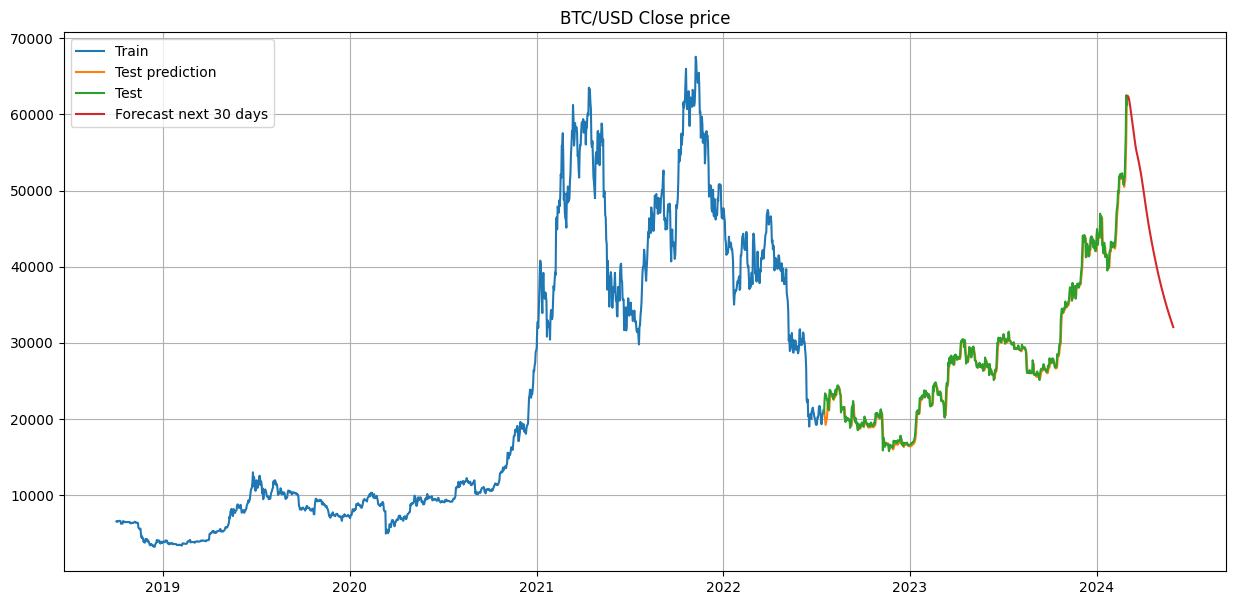

In [18]:
# Dateframe of Close training set
df_train = df_filtered['Close'][:train_size].copy()

# Plot the forecast for df_val, df_test and df_forecast
plt.figure(figsize=(15, 7))
plt.plot(df_train, label='Train')
plt.plot(df_test['Y_test_pred'], label='Test prediction')
plt.plot(df_test['Y_test'], label='Test')
plt.plot(df_forecast_unscale['Close'], label='Forecast next 30 days')
plt.title('BTC/USD Close price')
plt.grid()
plt.legend()
plt.show()


In [19]:
# Model Evaluation
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    return rmse, mape, smape

# Calculate the metrics df_test
rmse, mape, smape = calculate_metrics(df_test['Y_test'], df_test['Y_test_pred'])
print('Metrics for Test Data:')
print('RMSE: ', rmse)
print('MAPE: ', mape)
print('SMAPE: ', smape)

Metrics for Test Data:
RMSE:  855.5275869983736
MAPE:  1.9332817949492171
SMAPE:  1.9547145227125546
